In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_import import ag_merged
plt.style.use("dark_background")
def leastsquares(A, b):
    import numpy.linalg as npl
    return npl.lstsq(A, b, rcond=None)[0]

In [21]:
negative = ag_merged.loc[ag_merged['% change binned'] == 'negative'].loc[:, ["TMAX", "TMIN", "TOTALPRCP"]].values.tolist()
positive = ag_merged.loc[ag_merged['% change binned'] == 'positive'].loc[:, ["TMAX", "TMIN", "TOTALPRCP"]].values.tolist()

agg_data = {
    'positive' : positive, 'negative' : negative }

positive_total = len(positive)
negative_total = len(negative)
total_len = positive_total + negative_total


In [22]:
A = np.zeros((total_len, 3))
A[0:positive_total, :] = agg_data['positive']
A[positive_total:total_len, :] = agg_data['negative']
A = np.hstack([np.ones((total_len, 1)), A])

In [23]:
y = np.zeros((total_len,1))
y[0:positive_total] = -1 
y[positive_total:] = 1

In [24]:
x = leastsquares(A,y)
yhat = A @ x
yhat

array([[0.08776805],
       [0.06983359],
       [0.04595092],
       ...,
       [0.02849627],
       [0.06860618],
       [0.04394425]])

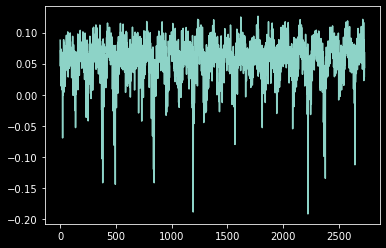

In [25]:
plt.plot(range(total_len), yhat)

In [26]:
y_n = np.zeros((total_len, 1))
y_n[0:positive_total] = 1
y_n[positive_total: total_len] = -1
x_n = leastsquares(A, y_n)
yhat_xn = A @ x_n

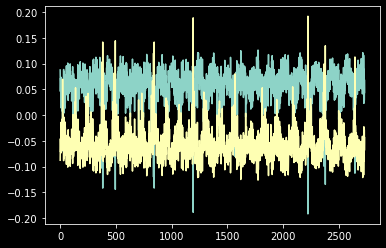

In [27]:
plt.plot(range(total_len),yhat, yhat_xn)

In [28]:
def fhat(row):
    y_positive = row @ x
    y_negative = row @ x_n
    outs = [y_positive, y_negative]
    if max(outs) == y_positive:
        return 'positive'
    else:
        return 'negative'

correct = ['positive'] * positive_total +  ['negative'] * negative_total

yhat_final = np.array([fhat(A[i, :]) for i in range(total_len)])
error_rate_final = sum(yhat_final != np.array(correct))/total_len


In [29]:
print(error_rate_final)

0.5331137943651665


In [30]:
def sign(yhat):
    return 2.0 * (yhat > 0) - 1.0

"""Function definitions for Performance metrics, from Table 14.1 and pg.287 in Introduction to Applied Linear Algebra"""

def error_rate(y,yhat,total_len):
    sum_fpfn = 0
    for i in range(total_len):
        if y[i] !=sign(yhat[i]):
            sum_fpfn += 1
    return sum_fpfn/total_len

def true_positive(y,yhat,total_len):
    sum_tp = 0
    sum_p = 0
    for i in range(total_len):
        if y[i] == 1:
            sum_p += 1
            if sign(yhat[i]) == 1:
                sum_tp += 1
    return sum_tp/sum_p
        
def false_positive(y,yhat,total_len):
    sum_fp = 0
    sum_n = 0
    for i in range(total_len):
        if y[i] != 1:
            sum_n += 1
            if sign(yhat[i]) == 1:
                sum_fp += 1
    return sum_fp/sum_n

def true_negative(y,yhat,total_len):
    sum_tn = 0
    sum_n = 0
    for i in range(total_len):
        if y[i] != 1:
            sum_n += 1
            if sign(yhat[i]) !=1:
                sum_tn += 1
    return sum_tn/sum_n
         
def precision(y,yhat,total_len):
    sum_tp = 0
    sum_fp = 0
    for i in range(total_len):
        if y[i] == 1 and sign(yhat[i]) == 1:
            sum_tp += 1
        if y[i] != 1 and sign(yhat[i]) == 1:
            sum_fp += 1
    return sum_tp/(sum_tp + sum_fp)

In [31]:
print(error_rate(y,yhat,total_len), error_rate(y_n,yhat_xn,total_len))
print(true_positive(y,yhat,total_len), true_positive(y_n,yhat_xn,total_len))
print(false_positive(y,yhat,total_len), false_positive(y_n,yhat_xn,total_len))
print(true_negative(y,yhat,total_len), true_negative(y_n,yhat_xn,total_len))
print(precision(y,yhat,total_len), precision(y_n,yhat_xn,total_len))

0.4668862056348335 0.4668862056348335
0.970954356846473 0.041181041181041184
0.9588189588189588 0.029045643153526972
0.041181041181041184 0.970954356846473
0.5322213798332069 0.5578947368421052


In [33]:
from tabulate import tabulate
data = [['Error Rate', error_rate(y,yhat,total_len), error_rate(y_n,yhat_xn,total_len)], 
        ['True Positive', true_positive(y,yhat,total_len), true_positive(y_n,yhat_xn,total_len)], 
        ['False Positive', false_positive(y,yhat,total_len), false_positive(y_n,yhat_xn,total_len)], 
        ['True Negative', true_negative(y,yhat,total_len), true_negative(y_n,yhat_xn,total_len)],[],['Final Error Rate', error_rate_final]]
print (tabulate(data, headers=["Calculated from Positives", "Calculated From Negatives", ]))

                    Calculated from Positives    Calculated From Negatives
----------------  ---------------------------  ---------------------------
Error Rate                           0.466886                    0.466886
True Positive                        0.970954                    0.041181
False Positive                       0.958819                    0.0290456
True Negative                        0.041181                    0.970954

Final Error Rate                     0.533114
